#### Tikhvinskiy, User ID: 136782149

<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Generative adversarial networks


В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения

In [5]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [6]:
# !unzip -q /content/gdrive/MyDrive/faces_dataset_small.zip -d ./faces
# !rm -r ./faces/__MACOSX

!unzip -q /content/gdrive/MyDrive/faces_dataset_128x128.zip -d ./faces

In [7]:
!ls 

faces  gdrive  sample_data


In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import copy
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

In [2]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]
 

def norm(img_tensors):
    return (img_tensors - stats[0][0]) / stats[1][0] 


def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(13, 13))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
    # ax.imshow(make_grid(images.detach()[:nmax], nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

In [3]:
def get_dataloader(image_size, batch_size, stats, DATA_DIR):
  """
  Builds dataloader for training data.
  Use tt.Compose and tt.Resize for transformations
  :param image_size: height and wdith of the image
  :param batch_size: batch_size of the dataloader
  :returns: DataLoader object 
  """
  # TODO: resize images, convert them to tensors and build dataloader
  train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    # tt.Resize(image_size),
    # tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)
    ]))
  train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
  return train_dl

In [4]:
DATA_DIR = './faces/'
image_size = 128
batch_size = 32
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

latent_size = 1024 # choose latent size
lr = 0.0002 #0.0005 # 0.0002
epochs = 250


#TODO: build dataloader and transfer it to device
train_dl = get_dataloader(image_size, batch_size, stats, DATA_DIR)

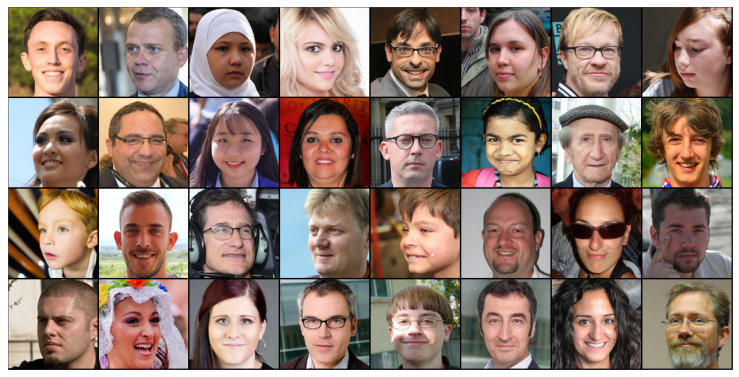

In [5]:
show_batch(train_dl)

In [6]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
train_dl = DeviceDataLoader(train_dl, device)

In [7]:
def mem_cuda(device=0):
    n = 1024 * 1024
    t = torch.cuda.get_device_properties(device).total_memory // n
    r = torch.cuda.memory_reserved(device) // n
    a = torch.cuda.memory_allocated(device) // n
    d = torch.cuda.get_device_name(device)
    f1 = t - (r + a)
    f2 = (r - a) # free inside reserved
    info = f'Device:{d}, all memory:{t}MB,  memory_reserved:{r}MB,  memory_allocated:{a}MB, free inside reserved:{f2}MB, free:{f1}MB'
    return info


torch.cuda.empty_cache()
mem_cuda()

'Device:Tesla P100-PCIE-16GB, all memory:16280MB,  memory_reserved:0MB,  memory_allocated:0MB, free inside reserved:0MB, free:16280MB'

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [8]:
discriminator = nn.Sequential(
    # in: 3 x 128 x 128
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 64 x 64

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 32 x 32

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 16 x 16

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 8 x 8

    nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 1024 x 4 x 4

    nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [9]:
discriminator = to_device(discriminator, device)

In [10]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1
    nn.ConvTranspose2d(latent_size, 1024, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),
    # out: 1024 x 4 x 4

    nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 8 x 8

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 16 x 16

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 32 x 32

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 64 x 64

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    # nn.Sigmoid())
    nn.Tanh())
    # out: 3 x 128 x 128

torch.Size([32, 1024, 1, 1])
torch.Size([32, 3, 128, 128])


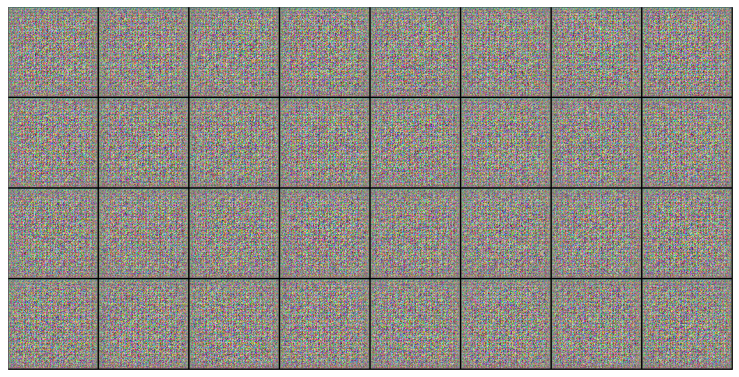

In [11]:
# посмотрим на выход генератора
xb = torch.randn(batch_size, latent_size, 1, 1) 
print(xb.shape)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [12]:
generator = to_device(generator, device)

In [13]:
def save_samples(index, latent_tensors, show=True, save=True, toColab=False):
    with torch.no_grad():
        fake_images = generator(latent_tensors)
        fake_fname = 'generated-images-{0:0=4d}.jpg'.format(index)
        if save and not toColab:
            save_image(denorm(fake_images)[:8], os.path.join(sample_dir, fake_fname), nrow=6)
            print('Saving', fake_fname)
        elif save and toColab:
            sample_dir = './gdrive/MyDrive/generatedGAN'
            save_image(denorm(fake_images)[:8], os.path.join(sample_dir, fake_fname), nrow=6)
            print('Saving', fake_fname)

        if show:
            fig, ax = plt.subplots(figsize=(21, 3))
            ax.set_xticks([]); ax.set_yticks([])
            ax.imshow(make_grid(denorm(fake_images)[:8].cpu().detach(), nrow=8).permute(1, 2, 0))
            plt.show()
    

sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

fixed_latent = torch.randn(batch_size, latent_size, 1, 1, device=device)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [14]:
model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }

In [15]:
def fit(model, criterion, epochs, lr, start_idx=1):
    print(mem_cuda())
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    next = 0
    # Create optimizers
    
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            # real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_targets = torch.FloatTensor(np.random.uniform(0.8, 1, (real_images.size(0), 1))).to(device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            # fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_targets = torch.FloatTensor(np.random.uniform(0, 0.2, (fake_images.size(0), 1))).to(device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())

        # каждую 60ю эпоху уменьшаем lr
        # if (epoch + 1) % 60 == 0:
        #     lr -= 0.0001
        #     optimizer["discriminator"].param_groups[0]['lr'] = lr
        #     optimizer["generator"].param_groups[0]['lr'] = lr

        # каждую 10ю эпоху сохраняем модель
        if (epoch + 1) % 10 == 0:
            model_save = copy.deepcopy(model)
            torch.save(model_save, "gdrive/MyDrive/model_gan_e200.pth")
            score_graph = losses_g + losses_d + real_scores + fake_scores
            torch.save(score_graph, "gdrive/MyDrive/score_graph_.pth")
            

        save_samples(epoch+start_idx, fixed_latent, show=False, save=True, toColab=True)
        
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        opt_d, opt_g = optimizer["discriminator"].param_groups[0]['lr'], optimizer["generator"].param_groups[0]['lr']

        clear_output(wait=True)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}, optimazer dis/gen={}/{}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1], 
            opt_d, opt_g))
    
        # промежуточные результаты
        save_samples(epoch+start_idx, fixed_latent, show=True, save=False)

        plt.figure(figsize=(20, 3))
        plt.plot(real_scores, label="real_scores")
        plt.plot(fake_scores, label="fake_scores")
        plt.legend(loc='best')
        plt.xlabel("epochs")
        plt.ylabel("scores")
        plt.show()  
        
        plt.figure(figsize=(20, 3))
        plt.plot(losses_g, label="losses_generator")
        plt.plot(losses_d, label="losses_discriminator")
        plt.legend(loc='best')
        plt.xlabel("epochs")
        plt.ylabel("loss")
        plt.show()  
        print(mem_cuda())
    
    return losses_g, losses_d, real_scores, fake_scores

Epoch [250/250], loss_g: 2.4103, loss_d: 0.6934, real_score: 0.8844, fake_score: 0.1167, optimazer dis/gen=0.0002/0.0002


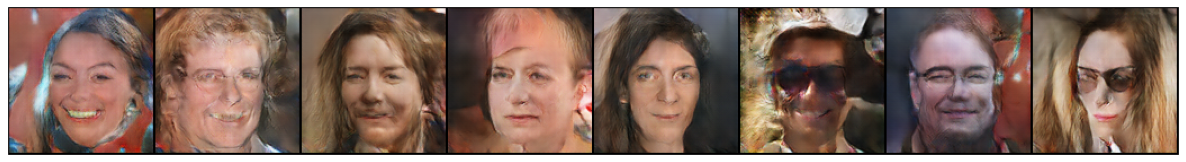

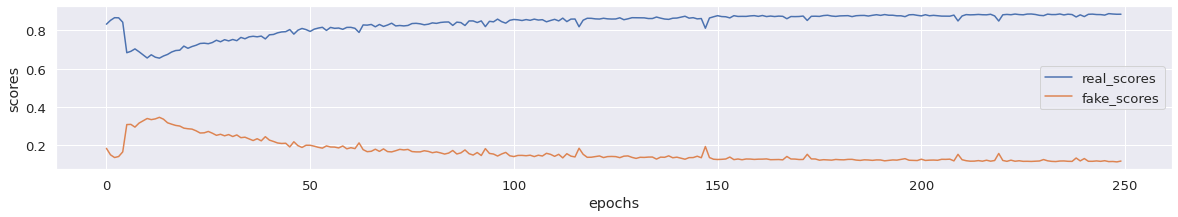

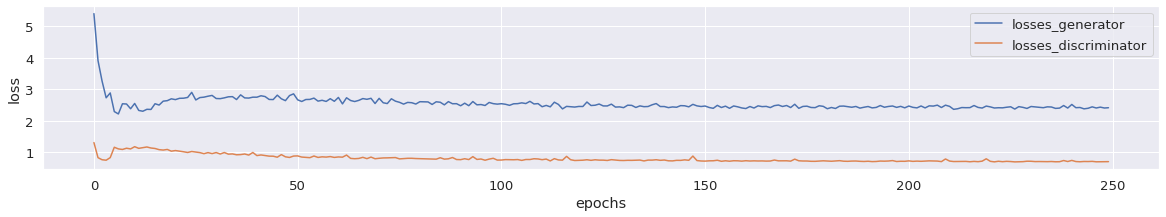

Device:Tesla P100-PCIE-16GB, all memory:16280MB,  memory_reserved:7534MB,  memory_allocated:753MB, free inside reserved:6781MB, free:7993MB


In [16]:
history = fit(model, criterion, epochs, lr)

In [17]:
# сохраним модель

# model_save = copy.deepcopy(model)
# torch.save(model_save, "gdrive/MyDrive/model_gan.pth")

# model = torch.load("gdrive/MyDrive/model_gan.pth")

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

Дискриминатор побеждает генератор. Хорошо распознает сгенерированные фотографии. 

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [18]:
def show_images(images):
    fig, ax = plt.subplots(figsize=(21, 10))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(fake_images).cpu().detach(), nrow=10).permute(1, 2, 0))
    plt.show()

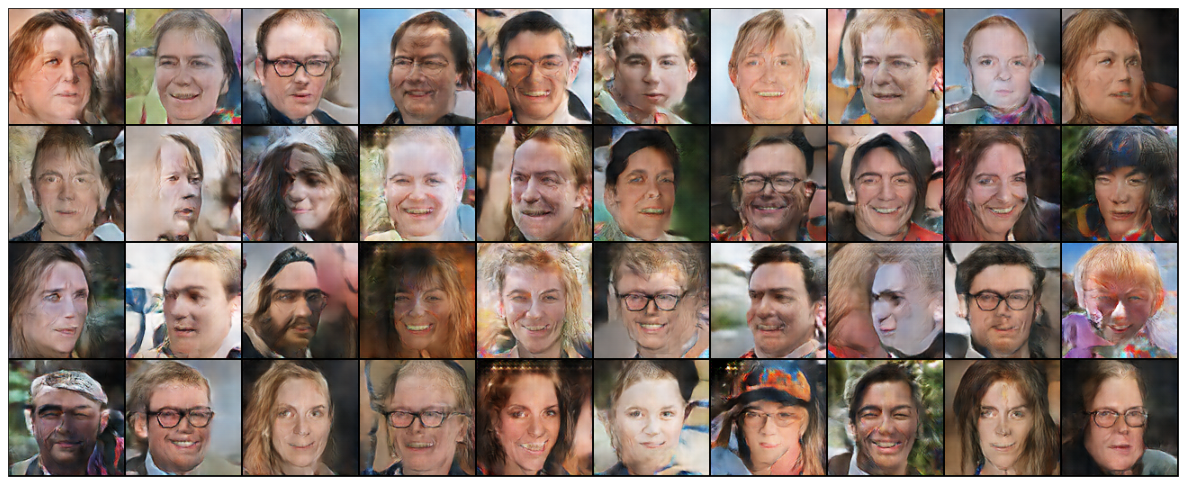

In [19]:
n_images = 40

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)
show_images(fake_images)

Как вам качество получившихся изображений?

Качество изображений лучше чем генерирует автоинкодер.

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [20]:
# для увеличения скорости обработки уменьшим размерность реальных картинок и синтезированных до 32х32х3

del train_dl
size = 32
train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([tt.Resize(size),tt.ToTensor(),tt.Normalize(*stats)]))
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [21]:
# добавим к реальным фото столько же синтезированных и вектор меток 1, 0

n = len(train_dl)
real_pic = [0] * n
fake = [0] * n
for i, real_images in enumerate(train_dl):
      clear_output(wait=True)
      print('Batch', i + 1, 'of', n)
      real_pic[i] = real_images[0].permute(0, 2, 3, 1)
      latent = torch.randn(batch_size,latent_size, 1, 1, device=device)
      fake_gen = model["generator"](latent).cpu().detach()
      fake[i] = tt.functional.resize(fake_gen, (size, size)).permute(0, 2, 3, 1)

X = real_pic + fake
X = np.vstack([picts.numpy() for picts in X])
X = X.reshape(X.shape[0], -1)
y = np.array([1] * (X.shape[0] // 2) + [0] * (X.shape[0] // 2 + 1))
X.shape, y.shape

Batch 99 of 99


((6311, 3072), (6311,))

In [22]:
%%time
# Построим leave-one-out оценку качества, для ускорения расчетов возьмем выборку изображений 

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier

sample = 2000
mid = X.shape[0] // 2
X_ = X[mid - (sample // 2): mid + (sample // 2)]
y_ = y[mid - (sample // 2): mid + (sample // 2)]

cf = KNeighborsClassifier(1)
score = cross_val_score(cf, X_, y_, scoring='accuracy', cv=LeaveOneOut(), n_jobs=-1, verbose=1).mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 14.4min


CPU times: user 12.1 s, sys: 1.44 s, total: 13.6 s
Wall time: 16min 4s


[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed: 16.1min finished


In [23]:
print('Leave-one-out-1-NN classifier accuracy= ', score)

Leave-one-out-1-NN classifier accuracy=  0.688


Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

Все-таки некоторые сгенерированные изображения классификатор не может отличить от настоящих. 
Лучшим результатом было бы accuracy равным 0.5, что означало бы случайные совпадения(классификатор не может различить изображения). 

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

CPU times: user 5min 8s, sys: 609 ms, total: 5min 9s
Wall time: 5min 7s


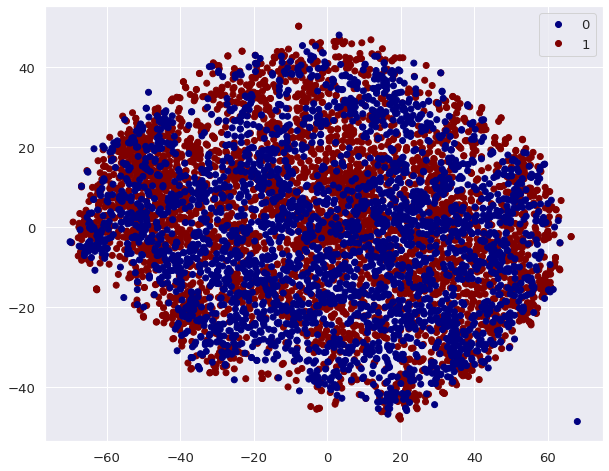

In [24]:
%%time
X_embedded = TSNE(n_components=2).fit_transform(X)
labels = y

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_embedded[:,0], X_embedded[:,1], c=labels, cmap='jet')
plt.legend(*scatter.legend_elements());

Прокомментируйте получившийся результат:

Сгенерированные и изначальные изображения похожи и не имеют четких границ разделения.